## License Plate Object Detection

Dataset Source: https://huggingface.co/datasets/keremberke/license-plate-object-detection/viewer/full/test

##### Install Necessary Libraries Not Already Installed

In [1]:
%pip install -q tensorboard albumentations timm

Note: you may need to restart the kernel to use updated packages.


##### Import Necessary Libraries

In [2]:
import os, sys, json

import numpy as np

import albumentations


from PIL import ImageDraw
import PIL.Image
from IPython.display import Image, display

from tqdm import tqdm

#from pycocotools.coco import COCO
#from pycocotools.cocoeval import COCOeval

import transformers
from transformers import AutoModelForObjectDetection, AutoImageProcessor
from transformers import TrainingArguments, Trainer

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset

from datasets import * 
from datasets import load_dataset

import evaluate

NOTE: Redirects are currently not supported in Windows or MacOs.


##### Display Versions of Relevant Libraries

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Torch Vision:".rjust(15), torchvision.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
         NumPy: 1.24.2
  Transformers: 4.26.1
         Torch: 1.12.1
  Torch Vision: 0.13.1
      Evaluate: 0.4.0


#### Load Dataset

In [4]:
ds = load_dataset("keremberke/license-plate-object-detection", name="full")
ds

Found cached dataset license-plate-object-detection (/Users/briandunn/.cache/huggingface/datasets/keremberke___license-plate-object-detection/full/1.0.0/e7740c5ed939eb2184b6f17aee84b3a304e2f46f093835a839bcf19f0ca38ce4)


A Jupyter Widget

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 6176
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1765
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 882
    })
})

##### Visualize Example

{0: 'license_plate'}
{'license_plate': 0}


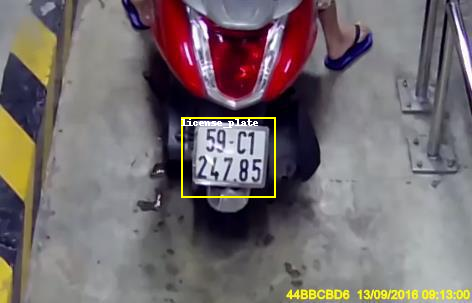

In [5]:
image = ds['train'][12]['image']

annotations = ds['train'][12]['objects']

draw = ImageDraw.Draw(image)

categories = ds["train"].features["objects"].feature["category"].names

id2label = {k: v for k, v in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

print(id2label)
print(label2id)

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="yellow", width=2)
    draw.text((x, y), id2label[class_idx], fill="white")
    
image

#### Basic Values/Constants

In [6]:
MODEL_CKPT = "facebook/detr-resnet-50"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-License_Plate_Object_Detection"

BATCH_SIZE = 8
DEVICE = torch.device("cpu")

LEARNING_RATE = 1e-5
NUM_OF_EPOCHS = 8

WEIGHT_DECAY = 1e-4

##### Preprocess Data

In [7]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_CKPT)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


DetrImageProcessor {
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}

#### Define Data Augmentations to Apply to Dataset

In [8]:
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0)
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"])
)

#### Reformat Annotations for Image Processor Expectations

In [9]:
def formatted_anns(image_id, category, area, bbox):
    annotations= []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)
    return annotations

#### Combine Image & Data Augmentations into Single Function

In [10]:
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

#### Apply Image & Data Augmentation Function to Training Dataset

In [11]:
ds["train"] = ds["train"].with_transform(transform_aug_ann)
ds["train"][12]

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


{'pixel_values': tensor([[[-0.5938, -0.5767, -0.5596,  ...,  0.0569,  0.0569,  0.0569],
          [-0.5767, -0.5767, -0.5596,  ...,  0.0569,  0.0569,  0.0569],
          [-0.5596, -0.5596, -0.5424,  ...,  0.0569,  0.0569,  0.0569],
          ...,
          [ 1.1358,  1.0331,  0.8961,  ..., -1.5357, -1.4500, -1.3987],
          [ 1.2043,  1.1015,  0.9303,  ..., -1.5357, -1.4500, -1.3987],
          [ 1.2557,  1.1358,  0.9474,  ..., -1.5357, -1.4500, -1.3987]],
 
         [[-0.6877, -0.6877, -0.6702,  ...,  0.0126,  0.0126,  0.0126],
          [-0.6877, -0.6877, -0.6702,  ...,  0.0126,  0.0126,  0.0126],
          [-0.6702, -0.6702, -0.6527,  ...,  0.0126,  0.0126,  0.0126],
          ...,
          [ 0.7304,  0.7479,  0.7654,  ...,  0.9055,  0.9230,  0.9405],
          [ 0.7654,  0.7654,  0.7829,  ...,  0.9055,  0.9230,  0.9405],
          [ 0.7829,  0.7829,  0.7829,  ...,  0.9055,  0.9230,  0.9405]],
 
         [[-0.4275, -0.4101, -0.3927,  ...,  0.1825,  0.1825,  0.1825],
          [-

#### Define Data Collator

In [12]:
def collate_function(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

##### Instantiate Model

In [13]:
model = AutoModelForObjectDetection.from_pretrained(
    MODEL_CKPT,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Training Arguments

In [14]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    save_steps=250,
    logging_steps=500,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    remove_unused_columns=False,
    push_to_hub=True
)

##### Instantiate Trainer

In [15]:
trainer = Trainer(
    model=model,
    args=args,
    data_collator=collate_function,
    train_dataset=ds['train'],
    tokenizer=image_processor,
)

Cloning https://huggingface.co/DunnBC22/detr-resnet-50-License_Plate_Object_Detection into local empty directory.


##### Train Model

In [16]:
training_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6176
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6176
  Number of trainable parameters = 41286406


A Jupyter Widget

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.
Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection/checkpoint-250
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-250/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-250/pytorch_model.bin
Image processor saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-250/preprocessor_config.json
Image processor

{'loss': 0.9789, 'learning_rate': 9.190414507772023e-06, 'epoch': 0.65}


Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection/checkpoint-750
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-750/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-750/pytorch_model.bin
Image p

{'loss': 0.6081, 'learning_rate': 8.380829015544043e-06, 'epoch': 1.3}


Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection/checkpoint-1250
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-1250/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-1250/pytorch_model.bin
Image processor saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-1250/preprocessor_conf

{'loss': 0.5666, 'learning_rate': 7.571243523316063e-06, 'epoch': 1.94}


Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection/checkpoint-1750
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-1750/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-1750/pytorch_model.bin
Image processor saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-1750/preprocessor_conf

{'loss': 0.5528, 'learning_rate': 6.761658031088083e-06, 'epoch': 2.59}


Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection/checkpoint-2250
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-2250/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-2250/pytorch_model.bin
Image processor saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-2250/preprocessor_conf

{'loss': 0.5499, 'learning_rate': 5.952072538860104e-06, 'epoch': 3.24}


Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection/checkpoint-2750
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-2750/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-2750/pytorch_model.bin
Image processor saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-2750/preprocessor_conf

{'loss': 0.5166, 'learning_rate': 5.1424870466321256e-06, 'epoch': 3.89}


Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection/checkpoint-3250
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-3250/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-3250/pytorch_model.bin
Image processor saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-3250/preprocessor_conf

{'loss': 0.5134, 'learning_rate': 4.332901554404146e-06, 'epoch': 4.53}


Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection/checkpoint-3750
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-3750/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-3750/pytorch_model.bin
Image processor saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-3750/preprocessor_conf

{'loss': 0.4956, 'learning_rate': 3.5233160621761657e-06, 'epoch': 5.18}


Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection/checkpoint-4250
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-4250/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-4250/pytorch_model.bin
Image processor saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-4250/preprocessor_conf

{'loss': 0.4833, 'learning_rate': 2.713730569948187e-06, 'epoch': 5.83}


Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection/checkpoint-4750
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-4750/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-4750/pytorch_model.bin
Image processor saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-4750/preprocessor_conf

{'loss': 0.4794, 'learning_rate': 1.9041450777202076e-06, 'epoch': 6.48}


Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection/checkpoint-5250
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-5250/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-5250/pytorch_model.bin
Image processor saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-5250/preprocessor_conf

{'loss': 0.4829, 'learning_rate': 1.0945595854922281e-06, 'epoch': 7.12}


Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection/checkpoint-5750
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-5750/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-5750/pytorch_model.bin
Image processor saved in detr-resnet-50-License_Plate_Object_Detection/checkpoint-5750/preprocessor_conf

{'loss': 0.4764, 'learning_rate': 2.849740932642487e-07, 'epoch': 7.77}


Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 454524.257, 'train_samples_per_second': 0.109, 'train_steps_per_second': 0.014, 'train_loss': 0.5562104709407826, 'epoch': 8.0}


#### Push Model to Hub (My Profile!!!!)

In [17]:
trainer.push_to_hub()

Saving model checkpoint to detr-resnet-50-License_Plate_Object_Detection
Configuration saved in detr-resnet-50-License_Plate_Object_Detection/config.json
Model weights saved in detr-resnet-50-License_Plate_Object_Detection/pytorch_model.bin
Image processor saved in detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json


A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/detr-resnet-50-License_Plate_Object_Detection
   6733319..9642836  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Object Detection', 'type': 'object-detection'}, 'dataset': {'name': 'license-plate-object-detection', 'type': 'license-plate-object-detection', 'config': 'full', 'split': 'train', 'args': 'full'}}
To https://huggingface.co/DunnBC22/detr-resnet-50-License_Plate_Object_Detection
   9642836..733b8fa  main -> main



'https://huggingface.co/DunnBC22/detr-resnet-50-License_Plate_Object_Detection/commit/96428368a70baaa44e01c3b9044fe21f8af5832f'

### Evaluate Model

#### Step 1: Prepare Test Dataset: Format Annotations

In [18]:
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)
    return annotations

#### Step 2: Save Data to Disk

In [24]:
def save_data_annotation_file_images(data):
    output_json = {}
    path_output_data = f"{os.getcwd()}/License Plate Detection"
    
    if not os.path.exists(path_output_data):
        os.makedirs(path_output_data)
    
    path_anno = os.path.join(path_output_data, "lp_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in data:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json
    
    with open(path_anno, "w") as f:
        json.dump(output_json, f, ensure_ascii=False, indent=4)
    
    for im, img_id in zip(data["image"], data["image_id"]):
        path_img = os.path.join(path_output_data, f"{img_id}.png")
        im.save(path_img)
    
    return path_output_data, path_anno

##### Step 3: Define CocoDetection Class

In [25]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image & target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image & target (converting target to DETR format, 
        # resizing + normalization of both image & target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return {"pixel_values": pixel_values, "labels": target}

##### Create Instance of CocoDetection Class

In [26]:
INFERENCE_MODEL = MODEL_NAME

img_processor = AutoImageProcessor.from_pretrained(INFERENCE_MODEL)

path_output_data, path_anno = save_data_annotation_file_images(ds["test"])
test_ds_coco_format = CocoDetection(path_output_data, img_processor, path_anno)

loading configuration file detr-resnet-50-License_Plate_Object_Detection/preprocessor_config.json
Image processor DetrImageProcessor {
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


##### Step 4: Load Metrics

In [27]:
model = AutoModelForObjectDetection.from_pretrained(INFERENCE_MODEL)
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_function
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        
        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]
        
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        
        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = img_processor.post_process(outputs, orig_target_sizes)
        
        module.add(prediction=results, reference=labels)
        del batch

loading configuration file detr-resnet-50-License_Plate_Object_Detection/config.json
Model config DetrConfig {
  "_name_or_path": "detr-resnet-50-License_Plate_Object_Detection",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "DetrForObjectDetection"
  ],
  "attention_dropout": 0.0,
  "auxiliary_loss": false,
  "backbone": "resnet50",
  "backbone_config": null,
  "bbox_cost": 5,
  "bbox_loss_coefficient": 5,
  "class_cost": 1,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "dice_loss_coefficient": 1,
  "dilation": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_coefficient": 0.1,
  "giou_cost": 2,
  "giou_loss_coefficient": 2,
  "id2label": {
    "0": "license_plate"
  },
  "init_std": 0.02,
  "init_xavier_std": 1.0,
  "is_encoder_decoder": true,
  "label2id": {
    "licen

##### Show Metrics

In [28]:
results = module.compute()
print(results)

Accumulating evaluation results...
DONE (t=0.56s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.547
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.603
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.616
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.617
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.399
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

### Notes & Other Takeaways
****
- This is improved compared to past object detection projects. I would prefer better metrics, but it is definitely a step in the right direction.
****

### Citations

- Dataset
    - @misc{ vehicle-registration-plates-trudk_dataset,
    title = { Vehicle Registration Plates Dataset },
    type = { Open Source Dataset },
    author = { Augmented Startups },
    howpublished = { \\url{ https://universe.roboflow.com/augmented-startups/vehicle-registration-plates-trudk } },
    url = { https://universe.roboflow.com/augmented-startups/vehicle-registration-plates-trudk },
    journal = { Roboflow Universe },
    publisher = { Roboflow },
    year = { 2022 },
    month = { jun },
    note = { visited on 2023-01-18 },
}

---

- Model Checkpoint
    - @article{DBLP:journals/corr/abs-2005-12872,
  author    = {Nicolas Carion and
               Francisco Massa and
               Gabriel Synnaeve and
               Nicolas Usunier and
               Alexander Kirillov and
               Sergey Zagoruyko},
  title     = {End-to-End Object Detection with Transformers},
  journal   = {CoRR},
  volume    = {abs/2005.12872},
  year      = {2020},
  url       = {https://arxiv.org/abs/2005.12872},
  archivePrefix = {arXiv},
  eprint    = {2005.12872},
  timestamp = {Thu, 28 May 2020 17:38:09 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/abs-2005-12872.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}